### Data Processing
In this notebook we will do:
 * Instrument response correction
 * Rotate data to the "great circle path"
 * Save the processed waveforms as SAC files (or another format of your choice)
 
**Notes:**
 Here I show you how to process the data using ObsPy, the goal here is to illustrate the general processing steps for waveform inversion. You can use whatever software of your choice to process your data (e.g. SAC, Matlab, etc.). I always recommend to save a copy of the raw uncorrected data and a copy of the instrument corrected data. This is important for reproducibility and quality control.

In [1]:
# Import third-party libraries
from pathlib import Path
import pandas as pd
from obspy import read, read_inventory, UTCDateTime
from obspy.geodetics.base import gps2dist_azimuth
from obspy.core.util.attribdict import AttribDict
import matplotlib.pyplot as plt

Define some parameters.

In [2]:
infile = "datetime.csv"
df = pd.read_csv(infile,parse_dates=True)
pre_filt = (0.004,0.007,10,20) # Data processing parameters
outfile_name = "station.csv"

Begin data processing.

In this tutorial we will process data from one earthquake, but you can easily process mulitple events by reading an input file that contains multiple event origins.

In [3]:
# We will go through the events in the Pandas table,
# if your table contains multiple events it will process all of them.

for index,row in df.iterrows():
    event_dir = row.evid
    outdir = "%s/sac"%event_dir # Output directory
    
    Path(outdir).mkdir(parents=True,exist_ok=True)
    df[index:index+1].to_csv("%s/%s"%(event_dir,"datetime.csv"),index=False) # save origin info to event directory

    # Read response files
    inv = read_inventory("%s/stations/*"%event_dir,format='STATIONXML')

    # Read data
    st = read("%s/waveforms/*"%event_dir,format='MSEED')

    # Detrend and remove instrument response
    st.detrend(type="linear") # equivalent to rtr in SAC
    st.remove_response(inventory=inv, pre_filt=pre_filt, output="DISP", zero_mean=True) # correct to displacement
    st.detrend(type="linear")
    st.detrend(type="demean") # remove mean

    # Define SAC headers and calculate back-azimtuh for rotation
    origin_time = UTCDateTime(row.origin)
    depth = row.depth*1000
    for tr in st:
        meta = inv.get_channel_metadata(tr.id)
        dist, az, baz = gps2dist_azimuth(row.lat,row.lon,meta['latitude'],meta['longitude'])
        omarker = origin_time - tr.stats.starttime

        # Obspy trace headers
        #tr.stats.coordinates = {'latitude':meta['latitude'], 'longitude':meta['longitude']}
        tr.stats.distance = dist
        tr.stats.back_azimuth = baz
        # SAC headers
        sacd = AttribDict()
        sacd.stla = meta['latitude']
        sacd.stlo = meta['longitude']
        sacd.stel = meta['elevation']
        sacd.evla = row.lat
        sacd.evlo = row.lon
        sacd.evdp = depth # in meters
        sacd.az = az
        sacd.baz = baz
        sacd.dist = dist/1000 # convert to kilometers
        sacd.o = 0
        sacd.b = -1*omarker
        tr.stats.sac = sacd

    # Rotate to ZNE
    st._rotate_to_zne(inv,components=("ZNE","Z12"))

    # Get station names
    netstaloccha = sorted(set(
            [(tr.stats.network, tr.stats.station, tr.stats.location, tr.stats.channel[:-1]) for tr in st]
            ))
    
    # Keep only three-component seismograms, then rotate horizontals to RT
    for net, sta, loc, cha in netstaloccha:
        traces = st.select(network=net,station=sta,location=loc,channel="%s[ZNE]"%cha)
        if len(traces) != 3:
            for tr in traces:
                st.remove(tr)
        else:
            traces.rotate(method="NE->RT")
    
    # Update station names
    netstaloccha = set(
        [(tr.stats.network, tr.stats.station, tr.stats.location, tr.stats.channel[:-1], "ZRT",
          tr.stats.sac.dist, tr.stats.sac.az, tr.stats.sac.stlo, tr.stats.sac.stla) for tr in st.select(component="Z")]
        )
    
    # Save station information to a Pandas table
    header = ("network","station","location","channel","component","distance","azimuth","longitude","latitude")
    df2 = pd.DataFrame(netstaloccha, columns=header)
    df2 = df2.sort_values("distance")
    df2.to_csv("%s/%s"%(event_dir,outfile_name),index=False)
    
    # Here I choose to save the data in SAC format
    print("Saving instrument corrected data to %s."%outdir)
    for tr in st:
        tr.write("%s/%s"%(outdir,tr.id),format="SAC")    
    

Saving instrument corrected data to 40191336/sac.


#### Plotting Seismograms
Let's take a look at the waveforms to determine the period band for moment tensor inversion. Regional earthquakes tend to have good signals in the intermediate period band (10-50 seconds). We can model this period range with a one-dimensional plane-layered Earth model.

We will apply the filter on a copy of the original seismograms.

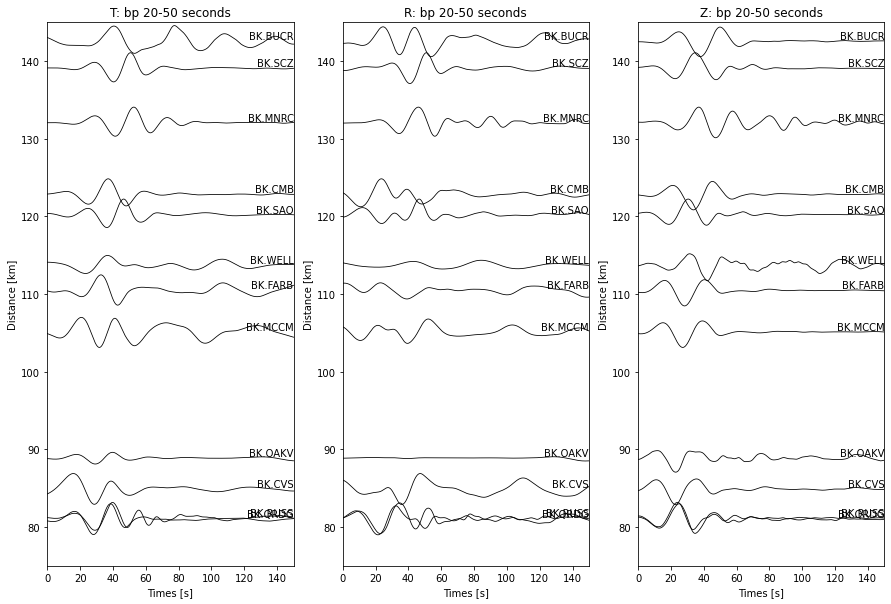

In [4]:
freqmin = 0.02
freqmax = 0.05
corners = 2
st_filt = st.copy()

# Apply filter and taper the edges
st_filt.filter("bandpass",freqmin=freqmin,freqmax=freqmax,corners=corners,zerophase=True)
st_filt.taper(max_percentage=0.05)

# Each seismogram is normalized against each trace
xmin = 0
xmax = 150
ymin = 75
ymax = 145
scale = 2 # scale the traces
fig, axes = plt.subplots(1,3,figsize=(15,10))
for component, ax in zip(("T","R","Z"),axes):
    for tr in st_filt.select(component=component):
        times = tr.times() - (origin_time - tr.stats.starttime)
        tr.data /= max(abs(tr.data))
        tr.data *= scale
        ax.plot(times,tr.data+tr.stats.sac.dist,color="black",linewidth=0.8)
        ax.text(xmax,tr.stats.sac.dist,"%s.%s"%(tr.stats.network,tr.stats.station),va="bottom",ha="right")
    ax.set_xlim(xmin,xmax)
    ax.set_ylim(ymin,ymax)
    ax.set_xlabel("Times [s]")
    ax.set_ylabel("Distance [km]")
    ax.set_title("%s: bp %.0f-%.0f seconds"%(component,1/freqmax,1/freqmin))

**We will move on to the next book on data and synthetics.**